# 12. ViT

## План

1. Архитектура Vision Transformer
2. SSL: DINO
3. Saliency Maps from Attention Maps
4. Low-Shot Learning (kNN, Linear Probing)

[Отчёт в Wandb по семинару (появится позже)]()

## 0. Ключ wandb

In [1]:
import wandb

wandb.login(key="a9601fb39e526b3b3897b1ff431af3d92ecdc749")
# wandb.login(key="YOUR KEY")
import black
import jupyter_black

jupyter_black.load(
    lab=True,
    line_length=120,
    target_version=black.TargetVersion.PY311,
)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

## 1. Архитектура Vision Transformer


- [Andrej Karpathy](https://karpathy.ai/) [считает](https://www.youtube.com/watch?v=9uw3F6rndnA&ab_channel=LexClips), что трансформер - лучшая идея в AI
- [PapersWithCode](https://paperswithcode.com/sota/image-classification-on-imagenet) - SotA по задачам зрения

<div>
<img src="./resources/popularity.png" width=70%/>
</div>



Сегодня сами напишем **ViT**!
Материалы для изучения:
* [Attention is all you need](https://arxiv.org/abs/1706.03762)
* [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)
* [How to train your ViT? Data, Augmentation,and Regularization in Vision Transformers](https://arxiv.org/pdf/2106.10270.pdf)
* [оригинальный ViT на Jax-е](https://github.com/google-research/vision_transformer)
* [ViT на PyTorch-е в timm](https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py)

Трансформер родился в NLP, где типичная задача состоит в обработке упорядоченной последовательности *токенов*, представляющих слова или их части. Для зрения архитектура не сильно отличается от классического Encoder Transformer-a и состоит из:

1. Tokenizer - берёт картинку и возвращает набор токенов
2. Transformer Encoder Block - пре-нормализация, MHA, MLP и residual connections 
3. Positional embeddings - способ кодирования позиционной информации о порядке токенов (для MHSA)
4. Classification token [CLS] - спецтокен, фичи которого используются для классификации special token whose features is expected to be used for the final class prediction
5. Classification head - MLP, делающий предсказание по [CLS]


<div>
<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/vit_architecture.jpg" width=70%/>
</div>

### Tokenizer

У нас нет необходимости думать о кодировании дискретных символов, но зато нужно решить только проблему с преобразованием пространства картинки в последовательность.

Токенизатор должен принять изображение, нарезать его на непересекающиеся патчи, вытянуть их в векторы и спроецировать линейным преобразованием в новое пространство. Можно делать это по-разному:
- MaxPooling + Linear
- Conv2d

In [2]:
import torch
from torch import nn


class PatchEmbed(nn.Module):
    """
    Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        assert img_size % patch_size == 0, f"{img_size} should be devided by {patch_size}"
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        # YOUR CODE
        self.proj = nn.Conv2d(in_channels=in_chans, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # B x num_patches x embed_dim
        # YOUR CODE
        return self.proj(x).flatten(2).transpose(2, 1)  # B x embed_dim x 14 x 14

In [3]:
import torch
from torch import nn


class PatchEmbed(nn.Module):
    """
    Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        assert img_size % patch_size == 0, f"{img_size} should be devided by {patch_size}"
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
        )  # B x C x (img_size // patch_size) x (img_size // patch_size)

    def forward(self, x):
        # B x num_patches x embed_dim
        return self.proj(x).flatten(2).transpose(1, 2)

In [4]:
tokenizer = PatchEmbed(img_size=80, patch_size=4, in_chans=3, embed_dim=15)
dummy_batch = torch.zeros((5, 3, 80, 80))
tokenizer_result = tokenizer(dummy_batch)
tokenizer_result.shape

torch.Size([5, 400, 15])

### Слой аттеншена, a.k.a. One-Head Scaled Dot-Product Self-Attention

- Каждый элемент выборки $X$ - последовательность фичей $x_i \in \mathbb{R}^D$ переменной длины: $X = \{x_1, x_2, \ldots, x_{n_i}\}$
- То есть $X$ это матрица: $X \in \mathbb{R}^{n_i \times D}$
- Параметры слоя - матрицы фиксированного размера: $W_Q, W_K, W_V \in \mathbb{R}^{D \times d}$
- Вычисление:
    - $Q = X W_Q$ размера $n_i \times d_k$
    - $K = X W_K$ размера $n_i \times d_k$
    - $V = X W_V$ размера $n_i \times d_v$
- $Q, K$ можно нормализовать

### Attention это "мягкий словарь"

- `{key1: value1, key2: value2, ...}`
- **Query** - запрос на поиск среди **Key**
- Пусть $q_i$ и $k_j$ нормализованы: $\|q_i\| = \|k_j\| = 1$
- Тогда $\alpha_{ij}=\langle q_i, k_j \rangle = \cos(\theta)$, где $\theta$ - угол между $q_i$ и $k_j$, можно мерить косинусную схожесть
- Мы хотим померить релевантность всех ключей $k_j, j \in [d]$ запросу $q_i$
- Ответом на $i$-тый запрос будет вернуть линейную комбинацию всех **Value** с найденными скорами релевантности $\alpha_{ij}$

<img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/attention_example.svg" style="width:75%">


$$\text{Attention}(Q, K, V) = \operatorname{Row-Wise\ Softmax}\left(\dfrac{Q K^\top}{\sqrt{d_k}}\right) V$$   

*Как быть с нормализацией?*
$$
q \sim \mathcal{N}(0, \sigma^2), k \sim \mathcal{N}(0, \sigma^2) \rightarrow \mathbb{V} \left[ \sum_{i=1}^{d_k} q_i k_i\right] = \sum_{i=1}^{d_k} \mathbb{V} \left[  q_i k_i\right] = \sum_{i=1}^{d_k} \mathbb{V}\left[  q_i\right]\mathbb{V} \left[k_i\right]= \sigma^4 d_k
$$
Стандартное отклонение будет пропорционально $\sigma \sqrt{d_k}$, отсюда нормализация.

Если мы не уменьшим дисперсию обратно до $\sigma^2$, то софтмакс по логитам уже насытится до $1$ для одного случайного элемента и $0$ для всех остальных. Градиенты через softmax затухнут, так что мы не сможем выучить параметры должным образом. 

На $\sigma$ мы не масштабируем, так как при инициализации весов обычно $\sigma << 1$.

### Multi-Head Attention (MHA)
<img src="https://data-science-blog.com/wp-content/uploads/2022/01/mha_img_original.png" style="width:75%">

- Разделяем каждый вектор из $Q, K, V$ на `num_heads` подвекторов с помощью идентичных линейных проекций $h$ раз ($D \mod h = 0$)
- Применяем Attention независимо, соединяем результаты

$$ 
\begin{align*}
\text{Multihead}(Q, K, V) = \textrm{concat} \left( \text{head}_1, \text{head}_2, \ldots, \text{head}_h \right) W_O,\\
\text{head}_i = \text{Attention}(Q_i, K_i, V_i), i = [h]; W_O \in \mathbb{R}^{h d_v \times d_{out}}
\end{align*}
$$
- **Можно ли написать без цикла?**

In [5]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        # YOUR CODE
        # x: B x N x dim
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # qkv: 3 × B × num_heads × d × head_dim
        q, k, v = qkv[0], qkv[1], qkv[2]
        # v: B × num_heads × n × head_dim
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        # attn: B × num_heads × n × n
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        # B × num_heads × n × head_dim
        x = self.proj(x)
        # B × n × (num_heads × head_dim)
        x = self.proj_drop(x)
        return x, attn

In [6]:
x_in = torch.randn(11, 25, 40)

x, attn = Attention(40, 8)(x_in)
x.shape, attn.shape

(torch.Size([11, 25, 40]), torch.Size([11, 8, 25, 25]))

### Stochastic depth

Stochastic depth was introduced in [paper](https://arxiv.org/pdf/1603.09382.pdf) as a way of overfitting reduction. You can think of it as about dropout on residual branches. ResNet-block with stochastic depth module looks like `y = x + DropPath(ResidualNet(x))` instead of classic `y = x + ResidualNet(x)`

Let's implement `DropPath` module. Its only parameter is `drop_prob` - probability to zero-out its input. Don't forget to devide the result on `(1-drop_prob)` in order to fix mean value of output in train mode (as you did in the first homework in dropout implementation).

In [7]:
def drop_path(x, drop_prob: float = 0.0, training: bool = False):
    if drop_prob == 0.0 or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    # YOUR CODE: generate random tensor, binarize it, cast to x.dtype, multiply x by the mask,
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks)."""

    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

### Transformer Encoder Block
<img src="https://theaisummer.com/static/aa65d942973255da238052d8cdfa4fcd/7d4ec/the-transformer-block-vit.png" style="width:25%">

Собираем блок из нормализаций, MHA, Feed-Forward-а и skip connections


In [8]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [10]:
class Block(nn.Module):
    def __init__(
        self,
        dim,
        num_heads,
        mlp_ratio=4.0,
        qkv_bias=False,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
    ):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        # YOUR CODE
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

### Positional Encoding
До сих пор информация о позиции токена на картинке не учитывалась.
Можно либо выучить позиционные эмбеддинги с помощью SGD (как мы и поступим), либо использовать какую-то схему для генерации эмбеддингов. В оригинальном Трансформере предложили периодические позиционные эмбеддинги:

$$\text{emb}(p, 2i) = \sin(\frac{p}{10000^{2i/d}})$$
$$\text{emb}(p, 2i + 1) = \cos(\frac{p}{10000^{2i/d}})$$
где p, 2i, 2i+1 - индексы элемента последовательности, d - длина последовательности.

Традиционный способ использования эмбеддингов в торче - `torch.nn.Embedding`. Но в нашем случае проще использовать `torch.nn.Parameter`.

### [CLS]-токен

Ванильный Vision Transformer использует довольно необычный способ получения эмбеддинга всего изображения для окончательного предсказания. Он добавляет еще один токен, названный class-token, со своим собственным позиционным эмбеддингом, и берет его фичи в качестве окончательного эмбеддинга изображения. Альтернативный подход, заимствованный из CNN, заключается в использовании глобального mean pooling-а, что ещё и чуть экономнее по памяти. Будучи более простым в реализации, пулинг приводит к более простой интерпретации взаимодействия патчей (в ванильном ViT все межпатчевые связи могут быть выучены только через блоки внимания).

Однако в современных работах вы можете встретить оба подхода с равной вероятностью.

In [11]:
import math
import torch.nn.functional as F


class VisionTransformer(nn.Module):
    """Vision Transformer."""

    def __init__(
        self,
        img_size=[224],
        patch_size=16,
        in_chans=3,
        num_classes=0,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        qkv_bias=False,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.0,
        norm_layer=nn.LayerNorm,
        **kwargs,
    ):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim

        self.patch_embed = PatchEmbed(
            img_size=img_size[0], patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim
        )
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    num_heads=num_heads,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    qk_scale=qk_scale,
                    drop=drop_rate,
                    attn_drop=attn_drop_rate,
                    drop_path=dpr[i],
                    norm_layer=norm_layer,
                )
                for i in range(depth)
            ]
        )
        self.norm = norm_layer(embed_dim)

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def interpolate_pos_encoding(self, x, w, h):
        npatch = x.shape[1] - 1
        N = self.pos_embed.shape[1] - 1
        if npatch == N and w == h:
            return self.pos_embed
        class_pos_embed = self.pos_embed[:, 0]
        patch_pos_embed = self.pos_embed[:, 1:]
        dim = x.shape[-1]
        w0 = w // self.patch_embed.patch_size
        h0 = h // self.patch_embed.patch_size
        # we add a small number to avoid floating point error in the interpolation
        # see discussion at https://github.com/facebookresearch/dino/issues/8
        w0, h0 = w0 + 0.1, h0 + 0.1
        patch_pos_embed = F.interpolate(
            patch_pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
            scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
            mode="bicubic",
        )
        assert int(w0) == patch_pos_embed.shape[-2] and int(h0) == patch_pos_embed.shape[-1]
        patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

    def prepare_tokens(self, x):
        B, nc, w, h = x.shape
        x = self.patch_embed(x)  # patch linear embedding

        # add the [CLS] token to the embed patch tokens
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # add positional encoding to each token
        x = x + self.interpolate_pos_encoding(x, w, h)

        return self.pos_drop(x)

    def forward(self, x):
        x = self.prepare_tokens(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return x[:, 0]  # [CLS]

    def get_last_selfattention(self, x):
        x = self.prepare_tokens(x)
        for i, blk in enumerate(self.blocks):
            if i < len(self.blocks) - 1:
                x = blk(x)
            else:
                # return attention of the last block
                return blk(x, return_attention=True)

    def get_intermediate_layers(self, x, n=1):
        x = self.prepare_tokens(x)
        # we return the output tokens from the `n` last blocks
        output = []
        for i, blk in enumerate(self.blocks):
            x = blk(x)
            if len(self.blocks) - i <= n:
                output.append(self.norm(x))
        return output

In [12]:
model_config = {
    "img_size": [64],
    "patch_size": 8,
    "embed_dim": 192,
    "mlp_ratio": 2,
    "depth": 9,
    "qkv_bias": True,
}


model = VisionTransformer(**model_config)

## 2. SSL (DINO)

### Self-Supervision through Knowledge Distillation
<div class="row">
    <img src="./resources/simclr.png" width=40%/>
    <img src="./resources/dino.png" width=40%/>
</div>

In [13]:
import torch.nn.functional as F


class DINOLoss(nn.Module):
    def __init__(
        self,
        out_dim,
        ncrops,
        warmup_teacher_temp,
        teacher_temp,
        warmup_teacher_temp_epochs,
        nepochs,
        student_temp=0.1,
        center_momentum=0.9,
    ):
        super().__init__()
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.ncrops = ncrops
        self.register_buffer("center", torch.zeros(1, out_dim))
        # we apply a warm up for the teacher temperature because
        # a too high temperature makes the training instable at the beginning
        self.teacher_temp_schedule = np.concatenate(
            (
                np.linspace(warmup_teacher_temp, teacher_temp, warmup_teacher_temp_epochs),
                np.ones(nepochs - warmup_teacher_temp_epochs) * teacher_temp,
            )
        )

    def forward(self, student_output, teacher_output, epoch):
        """
        Cross-entropy between softmax outputs of the teacher and student networks.
        """
        student_out = student_output / self.student_temp
        student_out = student_out.chunk(self.ncrops)

        # teacher centering and sharpening
        temp = self.teacher_temp_schedule[epoch]
        teacher_out = F.softmax((teacher_output - self.center) / temp, dim=-1)
        teacher_out = teacher_out.detach().chunk(2)

        total_loss = 0
        n_loss_terms = 0
        for iq, q in enumerate(teacher_out):
            for v in range(len(student_out)):
                if v == iq:
                    # we skip cases where student and teacher operate on the same view
                    continue
                loss = torch.sum(-q * F.log_softmax(student_out[v], dim=-1), dim=-1)
                total_loss += loss.mean()
                n_loss_terms += 1
        total_loss /= n_loss_terms
        self.update_center(teacher_output)
        return total_loss

    @torch.no_grad()
    def update_center(self, teacher_output):
        """
        Update center used for teacher output.
        """
        batch_center = torch.sum(teacher_output, dim=0, keepdim=True)
        batch_center = batch_center / (len(teacher_output))

        # ema update
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)

In [14]:
from torchvision import transforms as T
import utils

img_mean, img_std = (0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821)


class DataAugmentationDINO(object):
    def __init__(self, global_crops_scale, local_crops_scale, local_crops_number):
        flip_and_color_jitter = T.Compose(
            [
                T.RandomHorizontalFlip(p=0.5),
                T.RandomApply([T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8),
                T.RandomGrayscale(p=0.2),
            ]
        )
        normalize = T.Compose(
            [
                T.ToTensor(),
                T.Normalize(img_mean, img_std),
            ]
        )

        # first global crop
        self.global_transfo1 = T.Compose(
            [
                T.RandomResizedCrop(224, scale=global_crops_scale, interpolation=T.InterpolationMode("bicubic")),
                flip_and_color_jitter,
                utils.GaussianBlur(1.0),
                normalize,
            ]
        )
        # second global crop
        self.global_transfo2 = T.Compose(
            [
                T.RandomResizedCrop(224, scale=global_crops_scale, interpolation=T.InterpolationMode("bicubic")),
                flip_and_color_jitter,
                utils.GaussianBlur(0.1),
                utils.Solarization(0.2),
                normalize,
            ]
        )
        # transformation for the local small crops
        self.local_crops_number = local_crops_number
        self.local_transfo = T.Compose(
            [
                T.RandomResizedCrop(96, scale=local_crops_scale, interpolation=T.InterpolationMode("bicubic")),
                flip_and_color_jitter,
                utils.GaussianBlur(0.5),
                normalize,
            ]
        )

    def __call__(self, image):
        crops = []
        crops.append(self.global_transfo1(image))
        crops.append(self.global_transfo2(image))
        for _ in range(self.local_crops_number):
            crops.append(self.local_transfo(image))
        return crops

In [15]:
import utils


class DINOHead(nn.Module):
    def __init__(
        self, in_dim, out_dim, use_bn=False, norm_last_layer=True, nlayers=3, hidden_dim=2048, bottleneck_dim=256
    ):
        super().__init__()
        nlayers = max(nlayers, 1)
        if nlayers == 1:
            self.mlp = nn.Linear(in_dim, bottleneck_dim)
        else:
            layers = [nn.Linear(in_dim, hidden_dim)]
            if use_bn:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.GELU())
            for _ in range(nlayers - 2):
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                if use_bn:
                    layers.append(nn.BatchNorm1d(hidden_dim))
                layers.append(nn.GELU())
            layers.append(nn.Linear(hidden_dim, bottleneck_dim))
            self.mlp = nn.Sequential(*layers)
        self.apply(self._init_weights)
        self.last_layer = nn.utils.weight_norm(nn.Linear(bottleneck_dim, out_dim, bias=False))
        self.last_layer.weight_g.data.fill_(1)
        if norm_last_layer:
            self.last_layer.weight_g.requires_grad = False

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.mlp(x)
        x = F.normalize(x, dim=-1, p=2)
        x = self.last_layer(x)
        return x


model.dinohead = DINOHead(
    model_config["embed_dim"],
    out_dim=1024,
    hidden_dim=512,
    bottleneck_dim=256,
)

/home/jovyan/kurkin/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [16]:
def train_one_epoch(
    student,
    teacher,
    dino_loss,
    data_loader,
    optimizer,
    lr_schedule,
    wd_schedule,
    momentum_schedule,
    epoch,
    fp16_scaler,
    args,
):
    for it, (images, _) in enumerate(data_loader):
        # update weight decay and learning rate according to their schedule
        it = len(data_loader) * epoch + it  # global training iteration
        for i, param_group in enumerate(optimizer.param_groups):
            param_group["lr"] = lr_schedule[it]
            if i == 0:  # only the first group is regularized
                param_group["weight_decay"] = wd_schedule[it]

        # move images to gpu
        images = [im.cuda(non_blocking=True) for im in images]
        # teacher and student forward passes + compute dino loss
        with torch.cuda.amp.autocast(fp16_scaler is not None):
            teacher_output = teacher(images[:2])  # only the 2 global views pass through the teacher
            student_output = student(images)
            loss = dino_loss(student_output, teacher_output, epoch)

        if not math.isfinite(loss.item()):
            print("Loss is {}, stopping training".format(loss.item()), force=True)
            break

        # student update
        optimizer.zero_grad()
        param_norms = None
        if fp16_scaler is None:
            loss.backward()
            if args.clip_grad:
                param_norms = utils.clip_gradients(student, args.clip_grad)
            utils.cancel_gradients_last_layer(epoch, student, args.freeze_last_layer)
            optimizer.step()
        else:
            fp16_scaler.scale(loss).backward()
            if args.clip_grad:
                fp16_scaler.unscale_(optimizer)  # unscale the gradients of optimizer's assigned params in-place
                param_norms = utils.clip_gradients(student, args.clip_grad)
            utils.cancel_gradients_last_layer(epoch, student, args.freeze_last_layer)
            fp16_scaler.step(optimizer)
            fp16_scaler.update()

        # EMA update for the teacher
        with torch.no_grad():
            m = momentum_schedule[it]  # momentum parameter
            for param_q, param_k in zip(student.module.parameters(), teacher.parameters()):
                param_k.data.mul_(m).add_((1 - m) * param_q.detach().data)

In [16]:
import argparse
import os
import sys
import datetime
import time
import math
import json
from pathlib import Path

import torch.backends.cudnn as cudnn
from torchvision import datasets
from torchvision import models as torchvision_models

import utils
import vision_transformer as vits


def train_dino(args):
    utils.fix_random_seeds(args.seed)
    print("\n".join("%s: %s" % (k, str(v)) for k, v in sorted(dict(vars(args)).items())))
    cudnn.benchmark = True

    # ============ preparing data ... ============
    transform = DataAugmentationDINO(
        args.global_crops_scale,
        args.local_crops_scale,
        args.local_crops_number,
    )
    dataset = datasets.ImageFolder(args.data_path, transform=transform)
    sampler = torch.utils.data.DistributedSampler(dataset, shuffle=True)
    data_loader = torch.utils.data.DataLoader(
        dataset,
        sampler=sampler,
        batch_size=args.batch_size_per_gpu,
        num_workers=args.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    print(f"Data loaded: there are {len(dataset)} images.")

    # ============ building student and teacher networks ... ============
    # we changed the name DeiT-S for ViT-S to avoid confusions
    args.arch = args.arch.replace("deit", "vit")
    # if the network is a Vision Transformer (i.e. vit_tiny, vit_small, vit_base)
    if args.arch in vits.__dict__.keys():
        student = vits.__dict__[args.arch](
            patch_size=args.patch_size,
            drop_path_rate=args.drop_path_rate,  # stochastic depth
        )
        teacher = vits.__dict__[args.arch](patch_size=args.patch_size)
        embed_dim = student.embed_dim
    # otherwise, we check if the architecture is in torchvision models
    elif args.arch in torchvision_models.__dict__.keys():
        student = torchvision_models.__dict__[args.arch]()
        teacher = torchvision_models.__dict__[args.arch]()
        embed_dim = student.fc.weight.shape[1]
    else:
        print(f"Unknow architecture: {args.arch}")

    # multi-crop wrapper handles forward with inputs of different resolutions
    student = utils.MultiCropWrapper(
        student,
        DINOHead(
            embed_dim,
            args.out_dim,
            use_bn=args.use_bn_in_head,
            norm_last_layer=args.norm_last_layer,
        ),
    )
    teacher = utils.MultiCropWrapper(
        teacher,
        DINOHead(embed_dim, args.out_dim, args.use_bn_in_head),
    )
    # move networks to gpu
    student, teacher = student.cuda(), teacher.cuda()
    # teacher and student start with the same weights
    teacher.load_state_dict(student.module.state_dict())
    # there is no backpropagation through the teacher, so no need for gradients
    for p in teacher.parameters():
        p.requires_grad = False
    print(f"Student and Teacher are built: they are both {args.arch} network.")

    # ============ preparing loss ... ============
    dino_loss = DINOLoss(
        args.out_dim,
        args.local_crops_number + 2,  # total number of crops = 2 global crops + local_crops_number
        args.warmup_teacher_temp,
        args.teacher_temp,
        args.warmup_teacher_temp_epochs,
        args.epochs,
    ).cuda()

    # ============ preparing optimizer ... ============
    params_groups = utils.get_params_groups(student)
    if args.optimizer == "adamw":
        optimizer = torch.optim.AdamW(params_groups)  # to use with ViTs
    elif args.optimizer == "sgd":
        optimizer = torch.optim.SGD(params_groups, lr=0, momentum=0.9)  # lr is set by scheduler
    # for mixed precision training
    fp16_scaler = None
    if args.use_fp16:
        fp16_scaler = torch.cuda.amp.GradScaler()

    # ============ init schedulers ... ============
    lr_schedule = utils.cosine_scheduler(
        args.lr * (args.batch_size_per_gpu * utils.get_world_size()) / 256.0,  # linear scaling rule
        args.min_lr,
        args.epochs,
        len(data_loader),
        warmup_epochs=args.warmup_epochs,
    )
    wd_schedule = utils.cosine_scheduler(
        args.weight_decay,
        args.weight_decay_end,
        args.epochs,
        len(data_loader),
    )
    # momentum parameter is increased to 1. during training with a cosine schedule
    momentum_schedule = utils.cosine_scheduler(args.momentum_teacher, 1, args.epochs, len(data_loader))
    print(f"Loss, optimizer and schedulers ready.")

    # ============ optionally resume training ... ============
    to_restore = {"epoch": 0}
    utils.restart_from_checkpoint(
        os.path.join(args.output_dir, "checkpoint.pth"),
        run_variables=to_restore,
        student=student,
        teacher=teacher,
        optimizer=optimizer,
        fp16_scaler=fp16_scaler,
        dino_loss=dino_loss,
    )
    start_epoch = to_restore["epoch"]

    start_time = time.time()
    print("Starting DINO training !")
    for epoch in range(start_epoch, args.epochs):
        data_loader.sampler.set_epoch(epoch)

        # ============ training one epoch of DINO ... ============
        train_stats = train_one_epoch(
            student,
            teacher,
            dino_loss,
            data_loader,
            optimizer,
            lr_schedule,
            wd_schedule,
            momentum_schedule,
            epoch,
            fp16_scaler,
            args,
        )

        # ============ writing logs ... ============
        save_dict = {
            "student": student.state_dict(),
            "teacher": teacher.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch + 1,
            "args": args,
            "dino_loss": dino_loss.state_dict(),
        }
        if fp16_scaler is not None:
            save_dict["fp16_scaler"] = fp16_scaler.state_dict()
        torch.save(save_dict, os.path.join(args.output_dir, "checkpoint.pth"))
        if args.saveckp_freq and epoch % args.saveckp_freq == 0:
            torch.save(save_dict, os.path.join(args.output_dir, f"checkpoint{epoch:04}.pth"))
        log_stats = {**{f"train_{k}": v for k, v in train_stats.items()}, "epoch": epoch}
        with (Path(args.output_dir) / "log.txt").open("a") as f:
            f.write(json.dumps(log_stats) + "\n")
    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print("Training time {}".format(total_time_str))

In [18]:
utils.load_pretrained_weights(model, "checkpoints/vit_timnet_patch8_input64.pth", "student")

Take key student in provided checkpoint dict
Pretrained weights found at checkpoints/vit_timnet_patch8_input64.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['mask_token'])


In [25]:
model.cls_token.shape

torch.Size([1, 1, 192])

In [27]:
pos_embed_matrix = model.pos_embed.permute(1, 2, 0).detach().numpy()

model.pos_embed.shape

torch.Size([1, 65, 192])

In [20]:
import matplotlib.pyplot as plt

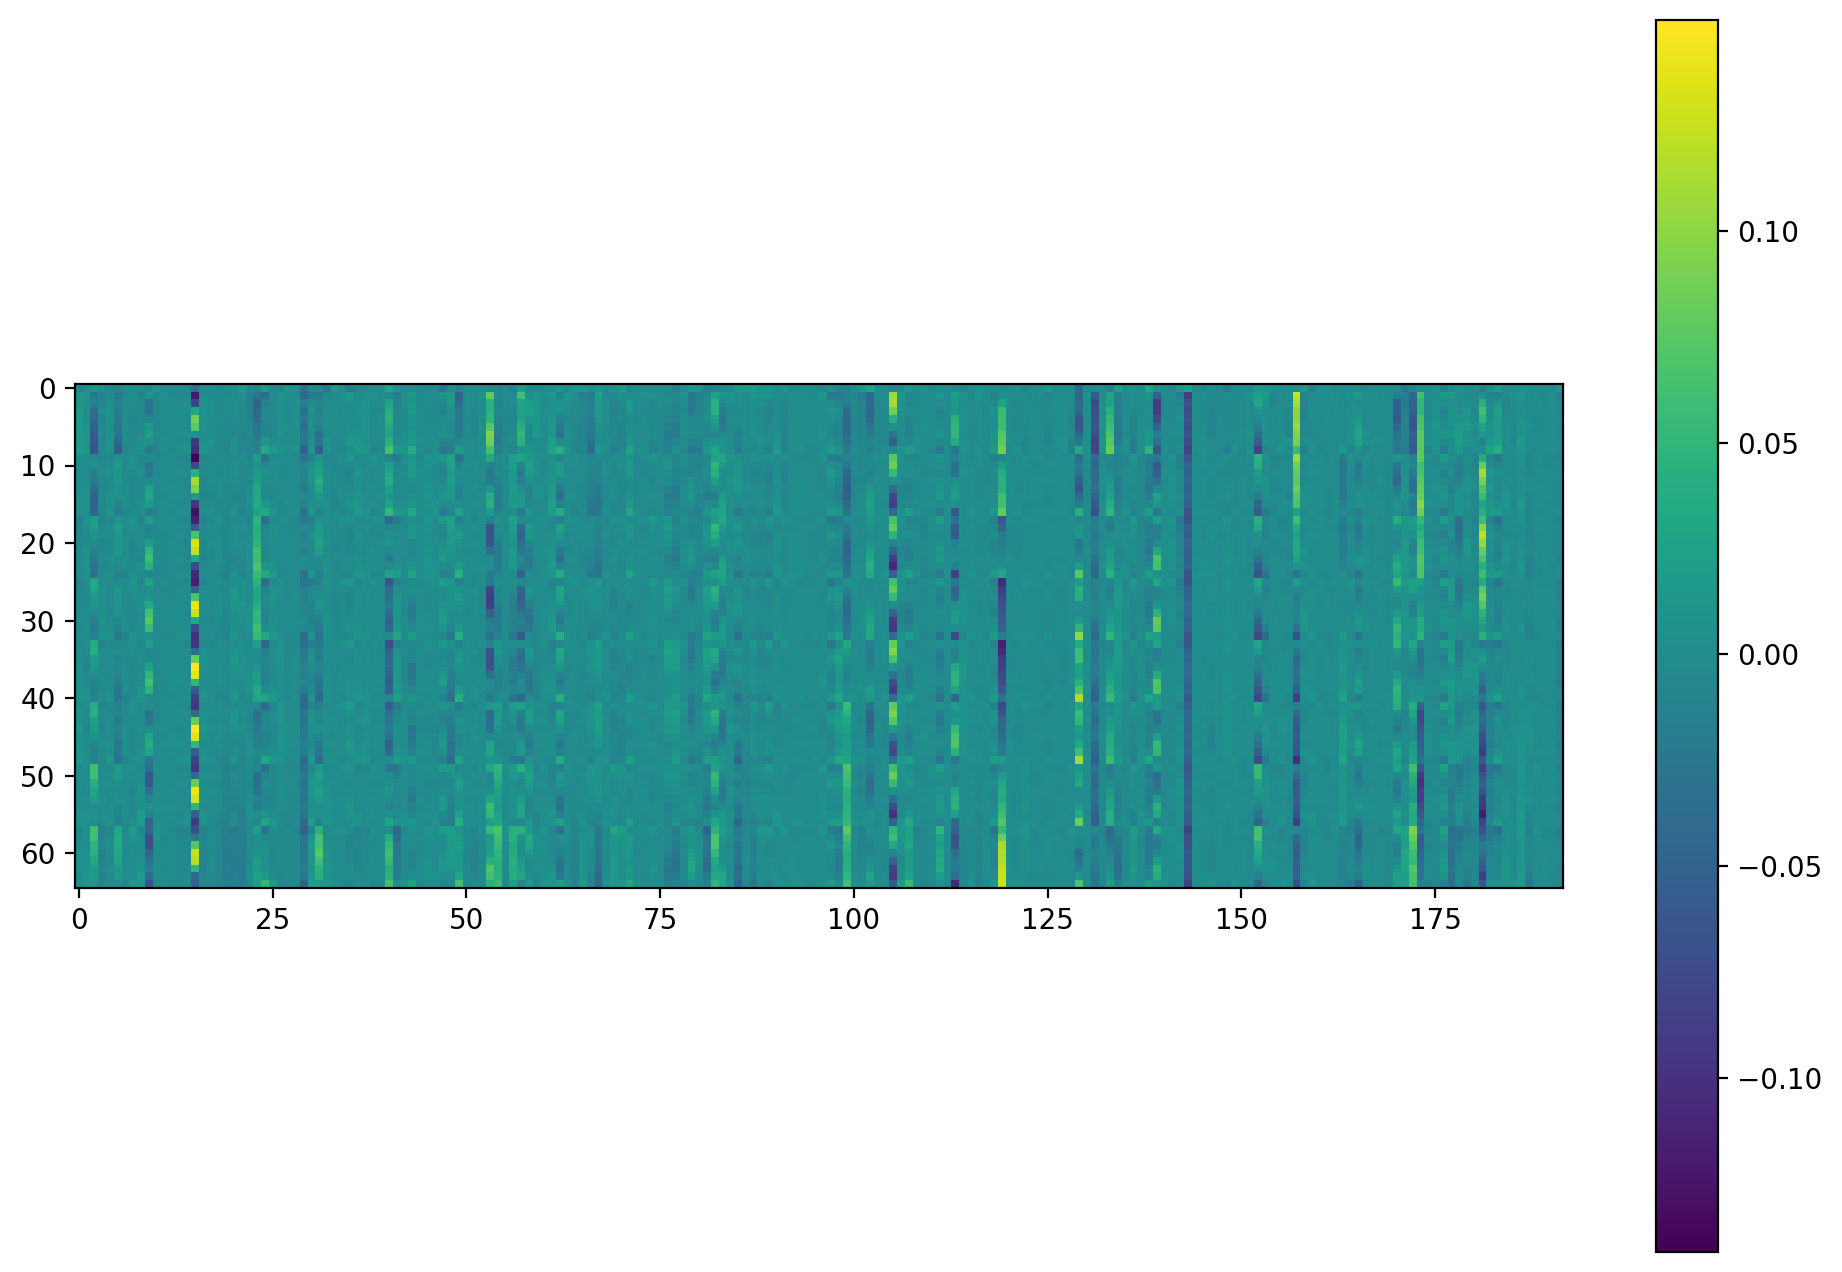

In [35]:
plt.figure(figsize=(12, 8))

plt.imshow(pos_embed_matrix)
plt.colorbar()

In [18]:
import os
from urllib.request import urlretrieve


def download_dataset(path, url="http://cs231n.stanford.edu/tiny-imagenet-200.zip"):
    dataset_name = "tiny-imagenet-200"

    if os.path.exists(os.path.join(path, dataset_name, "val", "n01443537")):
        print("%s already exists, skipping download" % os.path.join(path, dataset_name))
        return
    elif not os.path.exists(os.path.join(path, "tiny-imagenet-200" + ".zip")):
        print("Dataset doesn't exist or is broken, downloading it")
        urlretrieve(url, os.path.join(path, dataset_name + ".zip"))
        import zipfile

        with zipfile.ZipFile(os.path.join(path, "tiny-imagenet-200" + ".zip"), "r") as archive:
            archive.extractall()

    # move validation images to subfolders by class
    val_root = os.path.join(path, dataset_name, "val")
    with open(os.path.join(val_root, "val_annotations.txt"), "r") as f:
        for image_filename, class_name, _, _, _, _ in map(str.split, f):
            class_path = os.path.join(val_root, class_name)
            os.makedirs(class_path, exist_ok=True)
            os.rename(os.path.join(val_root, "images", image_filename), os.path.join(class_path, image_filename))

    os.rmdir(os.path.join(val_root, "images"))
    os.remove(os.path.join(val_root, "val_annotations.txt"))

In [19]:
download_dataset("datasets")

datasets/tiny-imagenet-200 already exists, skipping download


##  3. Saliency Maps from Attention Maps

In [87]:
img_mean, img_std = (0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821)

In [88]:
transform_val = T.Compose(
    [
        T.Resize(64),
        T.ToTensor(),
        T.Normalize(img_mean, img_std),
    ]
)

dataset_val = datasets.ImageFolder("datasets/tiny-imagenet-200/val/", transform=transform_val)

In [89]:
def tensor_to_image(tensor, mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25)):
    # mean, std ->
    mean = torch.tensor(mean)[:, None, None]
    std = torch.tensor(std)[:, None, None]

    renormalized_tensor = mean + std * tensor
    image = renormalized_tensor.permute(1, 2, 0).detach().cpu().numpy()

    return image

In [90]:
import matplotlib.pyplot as plt

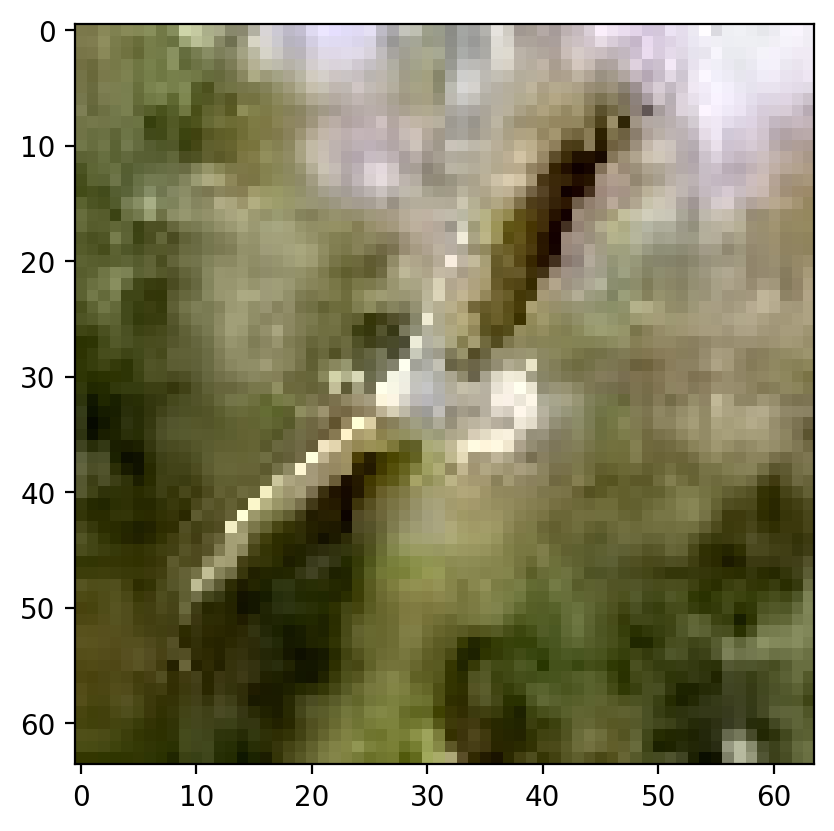

In [92]:
img, label = dataset_val[1000]

plt.imshow(tensor_to_image(img, img_mean, img_std))

In [93]:
import numpy as np
import colorsys
import random
from skimage.measure import find_contours
from matplotlib.patches import Polygon


def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image


def random_colors(N, bright=True):
    """
    Generate random colors.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def display_instances(image, mask, fname="test", figsize=(5, 5), blur=False, contour=True, alpha=0.5):
    fig = plt.figure(figsize=figsize, frameon=False)
    ax = plt.Axes(fig, [0.0, 0.0, 1.0, 1.0])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax = plt.gca()

    N = 1
    mask = mask[None, :, :]
    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    margin = 0
    ax.set_ylim(height + margin, -margin)
    ax.set_xlim(-margin, width + margin)
    ax.axis("off")
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        _mask = mask[i]
        if blur:
            _mask = cv2.blur(_mask, (10, 10))
        # Mask
        masked_image = apply_mask(masked_image, _mask, color, alpha)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        if contour:
            padded_mask = np.zeros((_mask.shape[0] + 2, _mask.shape[1] + 2))
            padded_mask[1:-1, 1:-1] = _mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8), aspect="auto")
    fig.savefig(fname)
    print(f"{fname} saved.")
    return

In [94]:
def get_attn_mask(img, model, model_config, threshold=None, output_dir="out"):
    # make the image divisible by the patch size
    w, h = img.shape[1:]
    w, h = w - w % model_config["patch_size"], w - w % model_config["patch_size"]
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // model_config["patch_size"]
    h_featmap = img.shape[-1] // model_config["patch_size"]

    with torch.no_grad():
        attentions = model.get_last_selfattention(img.to(next(model.parameters()).device))

    nh = attentions.shape[1]  # number of head

    # we keep only the output patch attention without [CLS]
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)

    if threshold is not None:
        # we keep only a certain percentage of the mass
        val, idx = torch.sort(attentions)
        val /= torch.sum(val, dim=1, keepdim=True)
        cumval = torch.cumsum(val, dim=1)
        th_attn = cumval > (1 - threshold)
        idx2 = torch.argsort(idx)
        for head in range(nh):
            th_attn[head] = th_attn[head][idx2[head]]
        th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
        th_attn = (
            F.interpolate(th_attn.unsqueeze(0), scale_factor=model_config["patch_size"], mode="nearest")[0]
            .cpu()
            .numpy()
        )

    # interpolate
    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = (
        F.interpolate(attentions.unsqueeze(0), scale_factor=model_config["patch_size"], mode="nearest")[0].cpu().numpy()
    )

    for j in range(nh):
        fname = os.path.join(output_dir, "attn-head" + str(j) + ".png")
        plt.imsave(fname=fname, arr=attentions[j], format="png")
        print(f"{fname} saved.")

    if threshold is not None:
        # image = torch.tensor(tensor_to_image(img.squeeze(0), img_mean, img_std))
        image = tensor_to_image(img.squeeze(0), img_mean, img_std) * 255.0
        for j in range(nh):
            display_instances(
                image,
                th_attn[j],
                fname=os.path.join(output_dir, "mask_th" + str(threshold) + "_head" + str(j) + ".png"),
                blur=False,
            )
    return attentions, th_attn

out/attn-head0.png saved.
out/attn-head1.png saved.
out/attn-head2.png saved.
out/attn-head3.png saved.
out/attn-head4.png saved.
out/attn-head5.png saved.
out/attn-head6.png saved.
out/attn-head7.png saved.
out/attn-head8.png saved.
out/attn-head9.png saved.
out/attn-head10.png saved.
out/attn-head11.png saved.
out/mask_th0.3_head0.png saved.
out/mask_th0.3_head1.png saved.
out/mask_th0.3_head2.png saved.
out/mask_th0.3_head3.png saved.
out/mask_th0.3_head4.png saved.
out/mask_th0.3_head5.png saved.
out/mask_th0.3_head6.png saved.
out/mask_th0.3_head7.png saved.
out/mask_th0.3_head8.png saved.
out/mask_th0.3_head9.png saved.
out/mask_th0.3_head10.png saved.
out/mask_th0.3_head11.png saved.


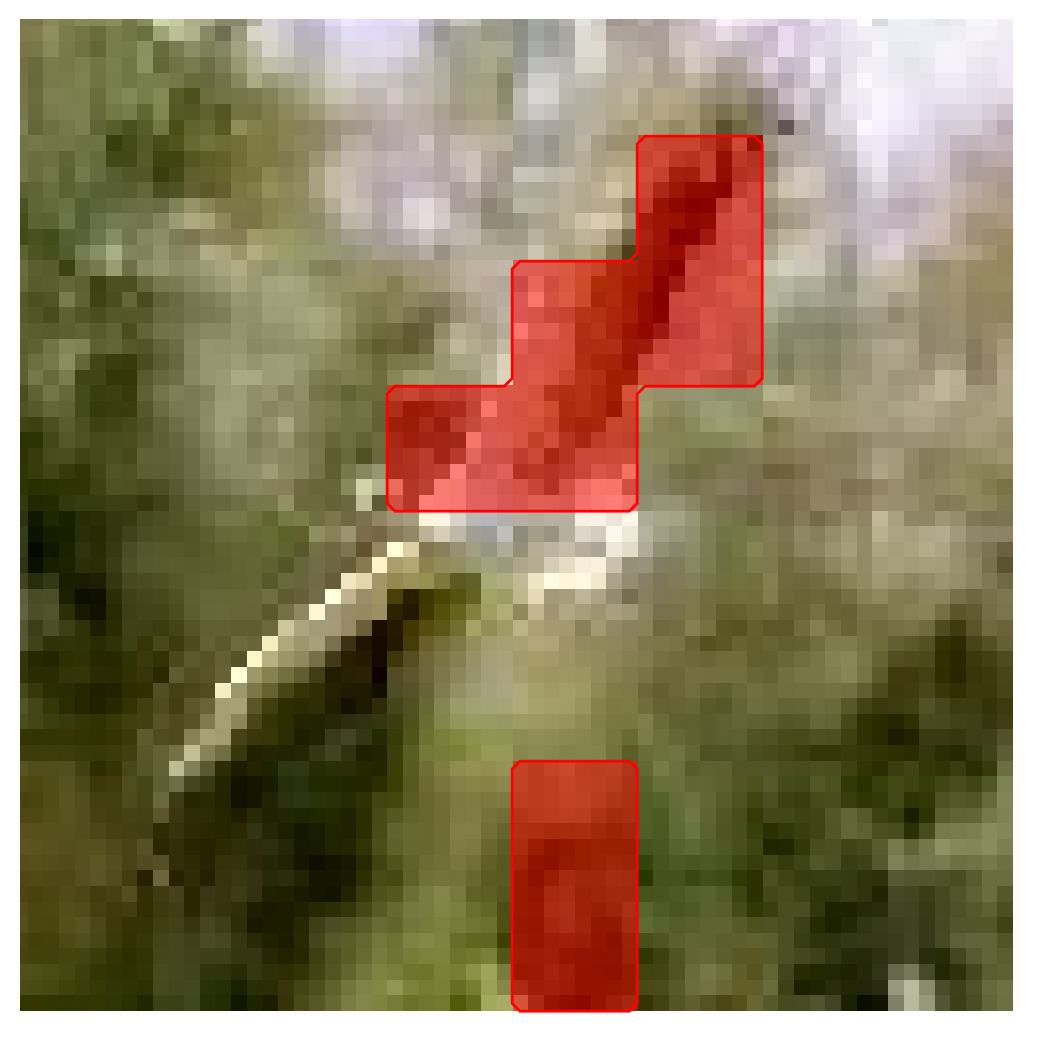

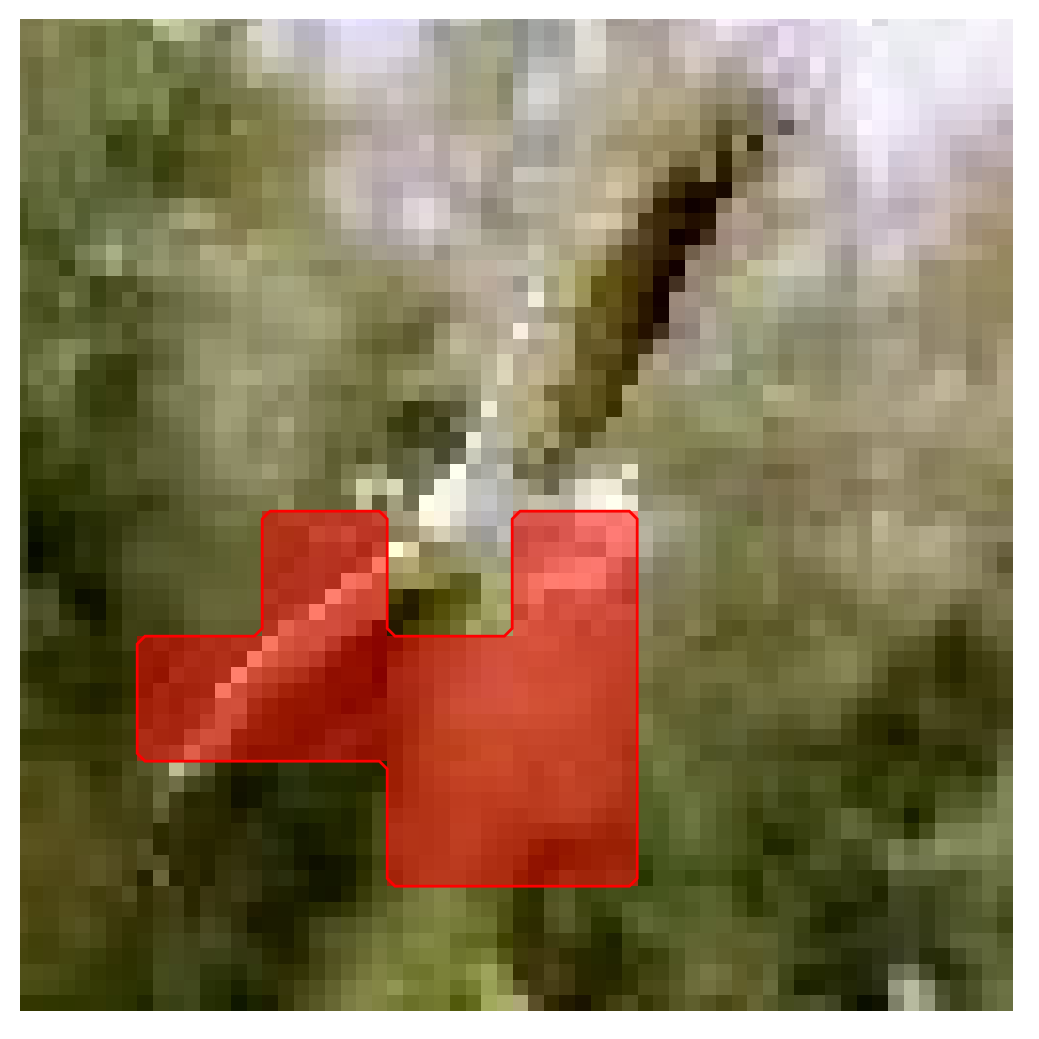

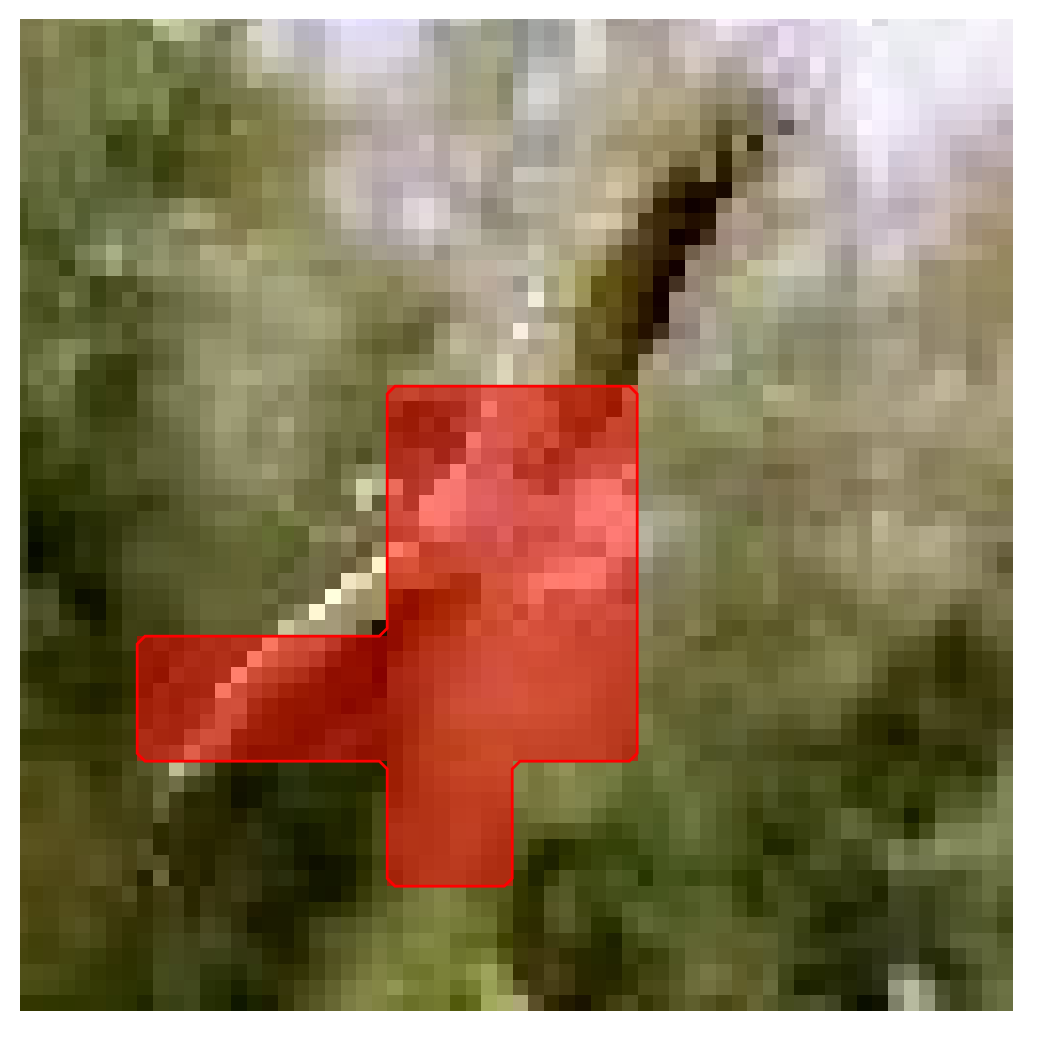

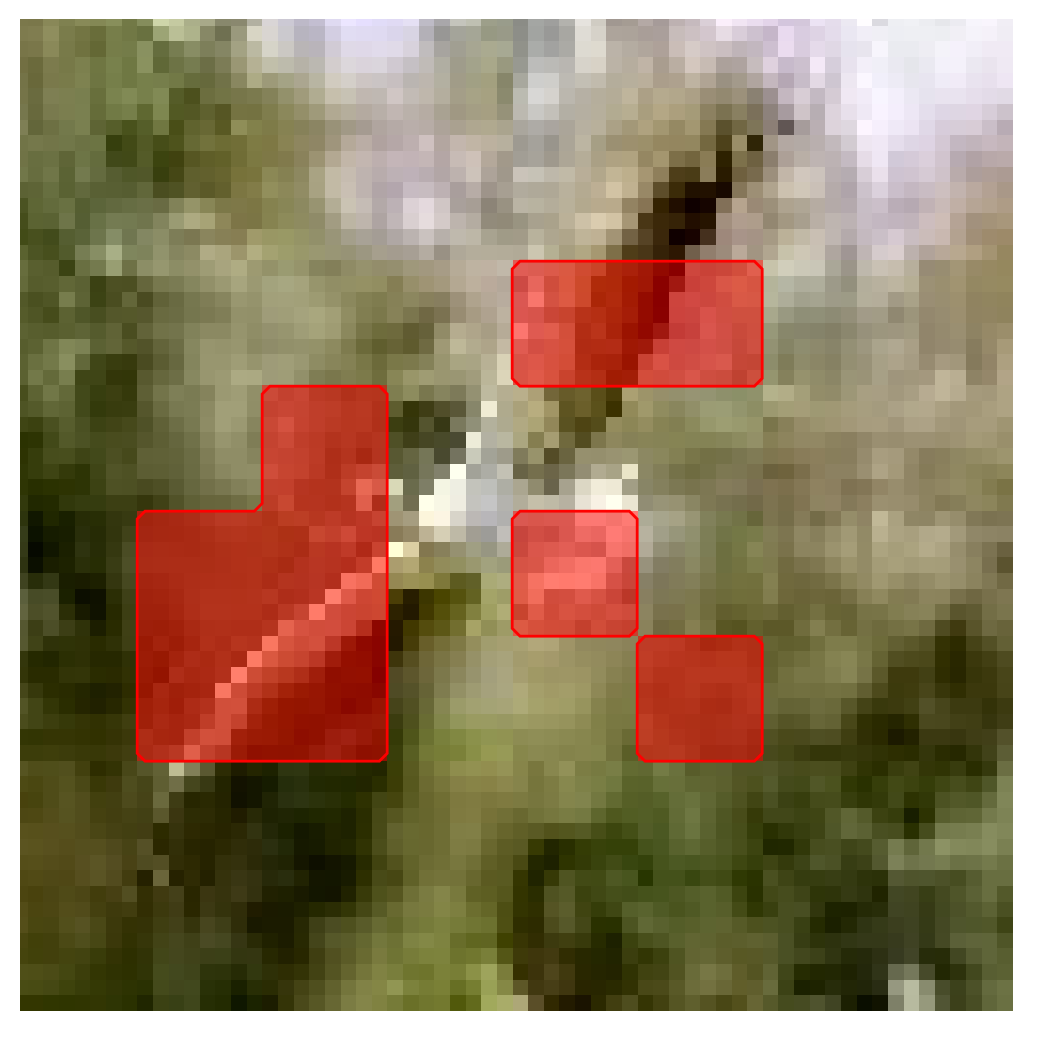

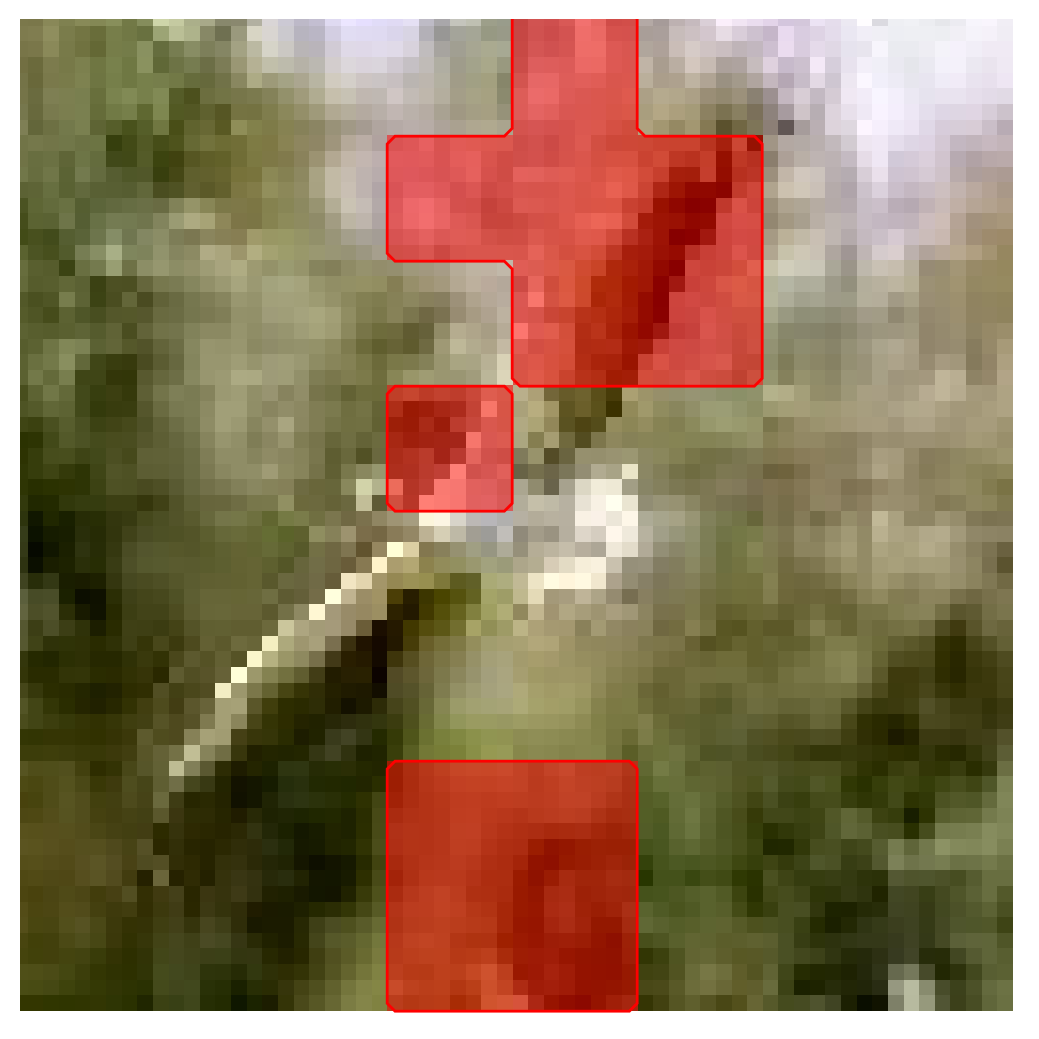

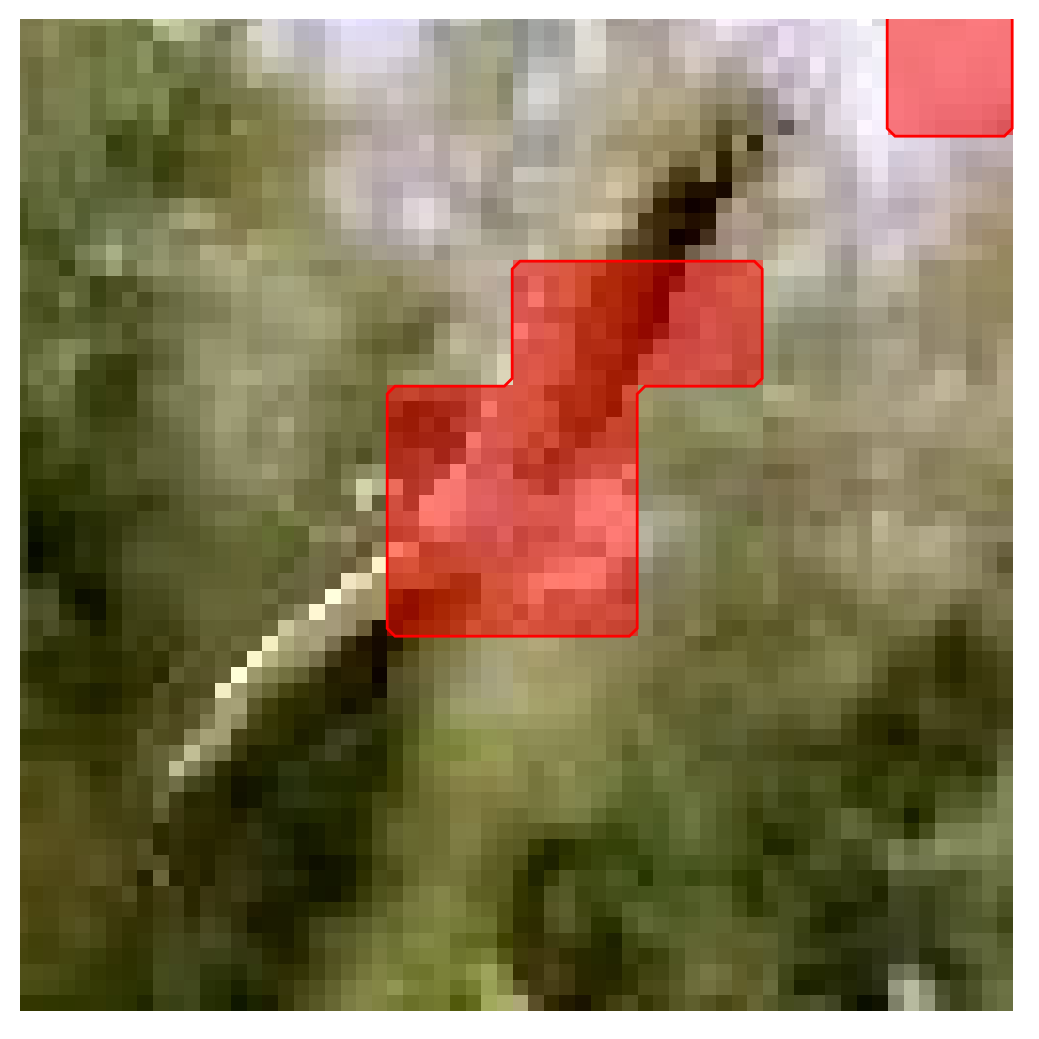

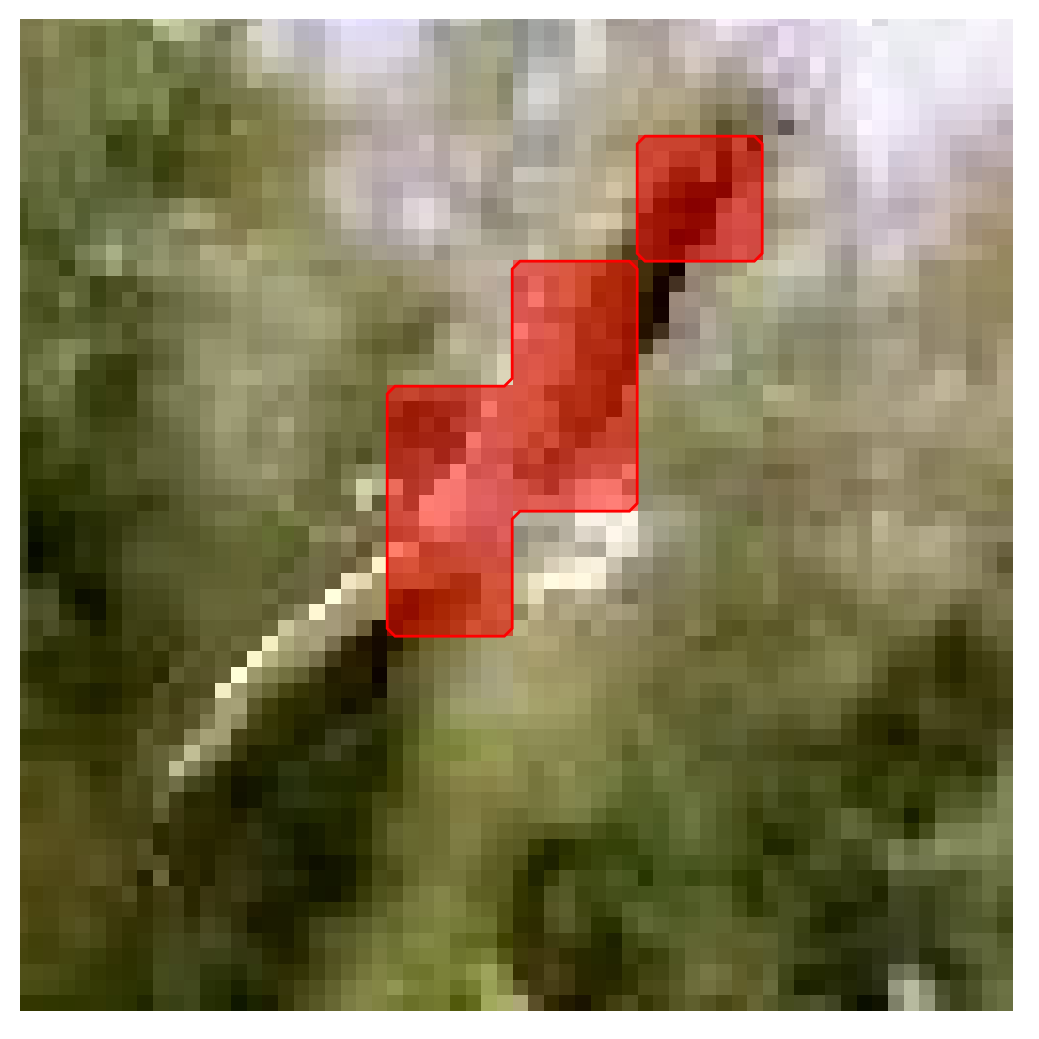

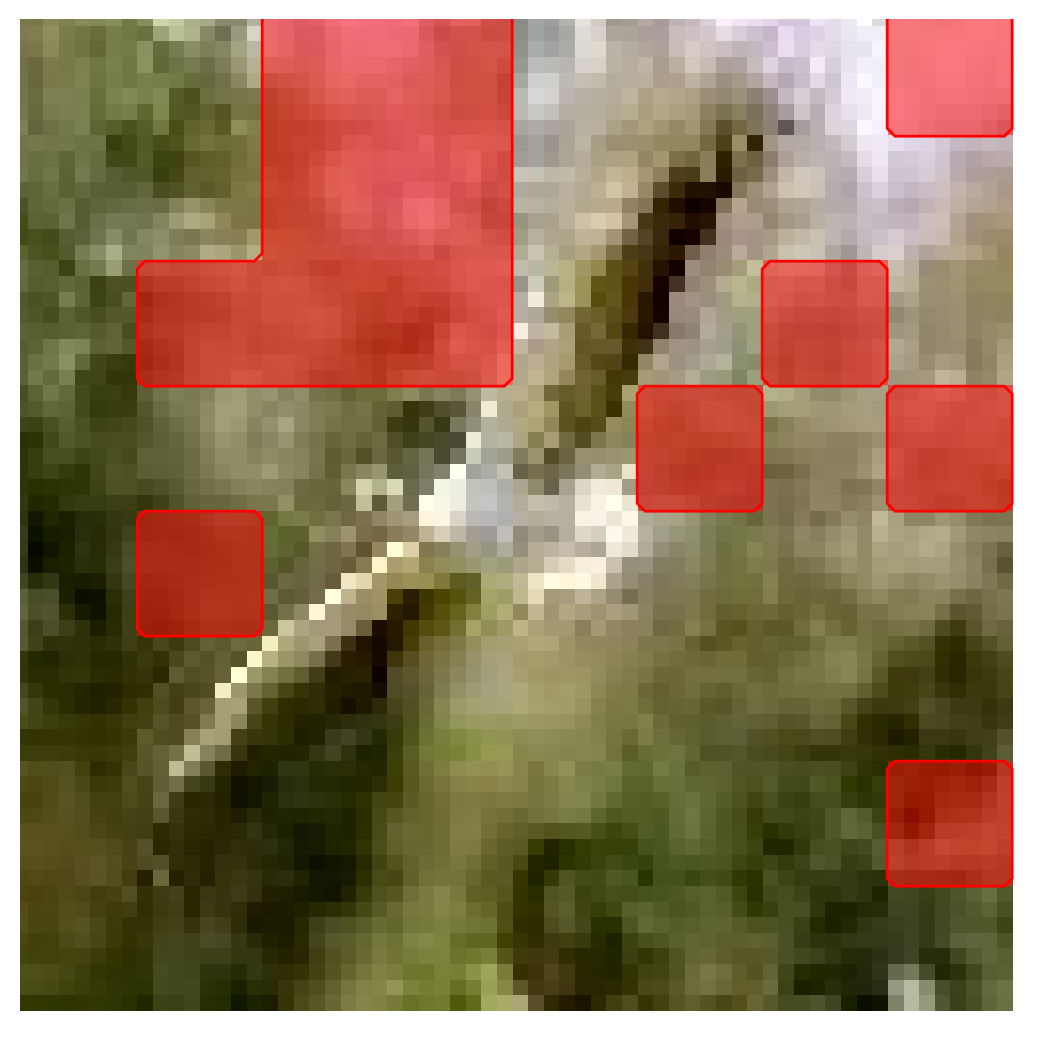

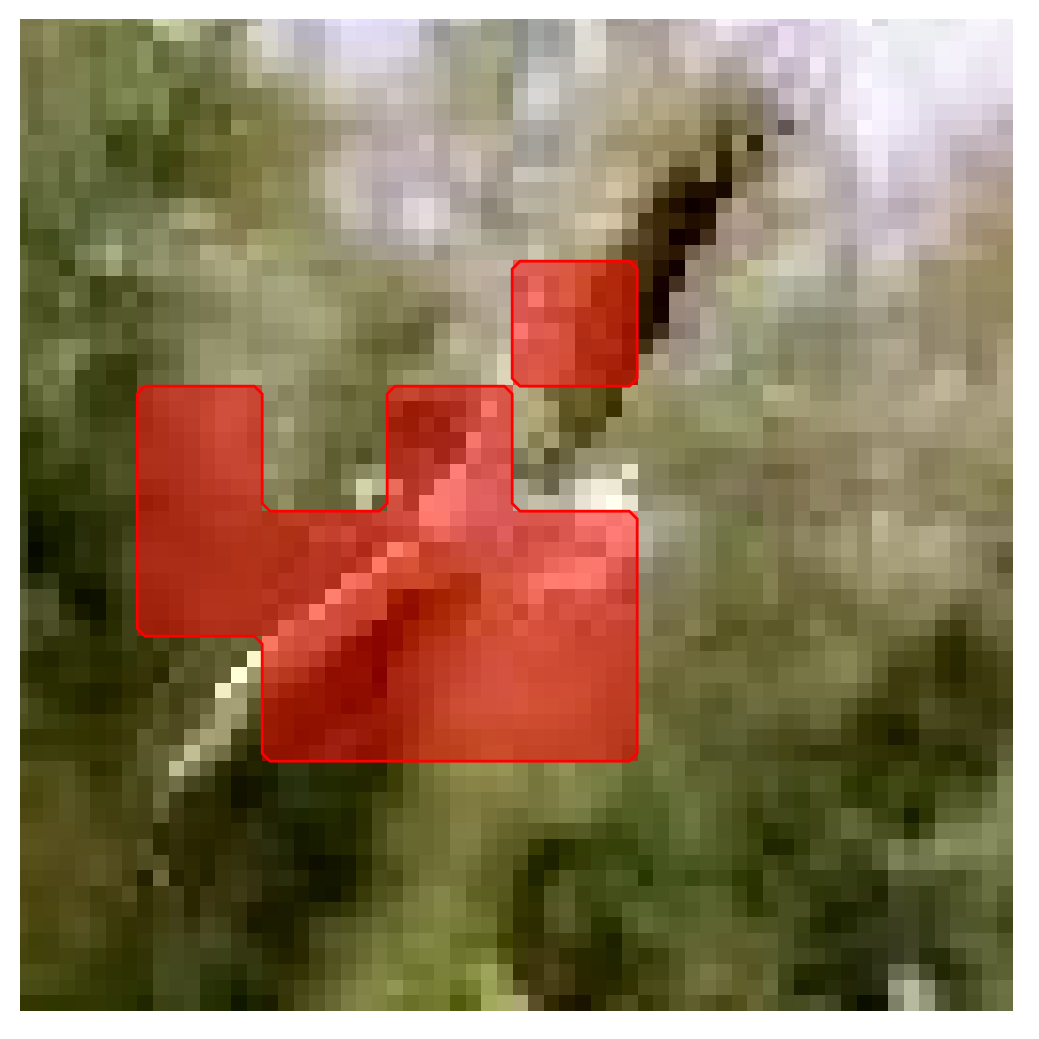

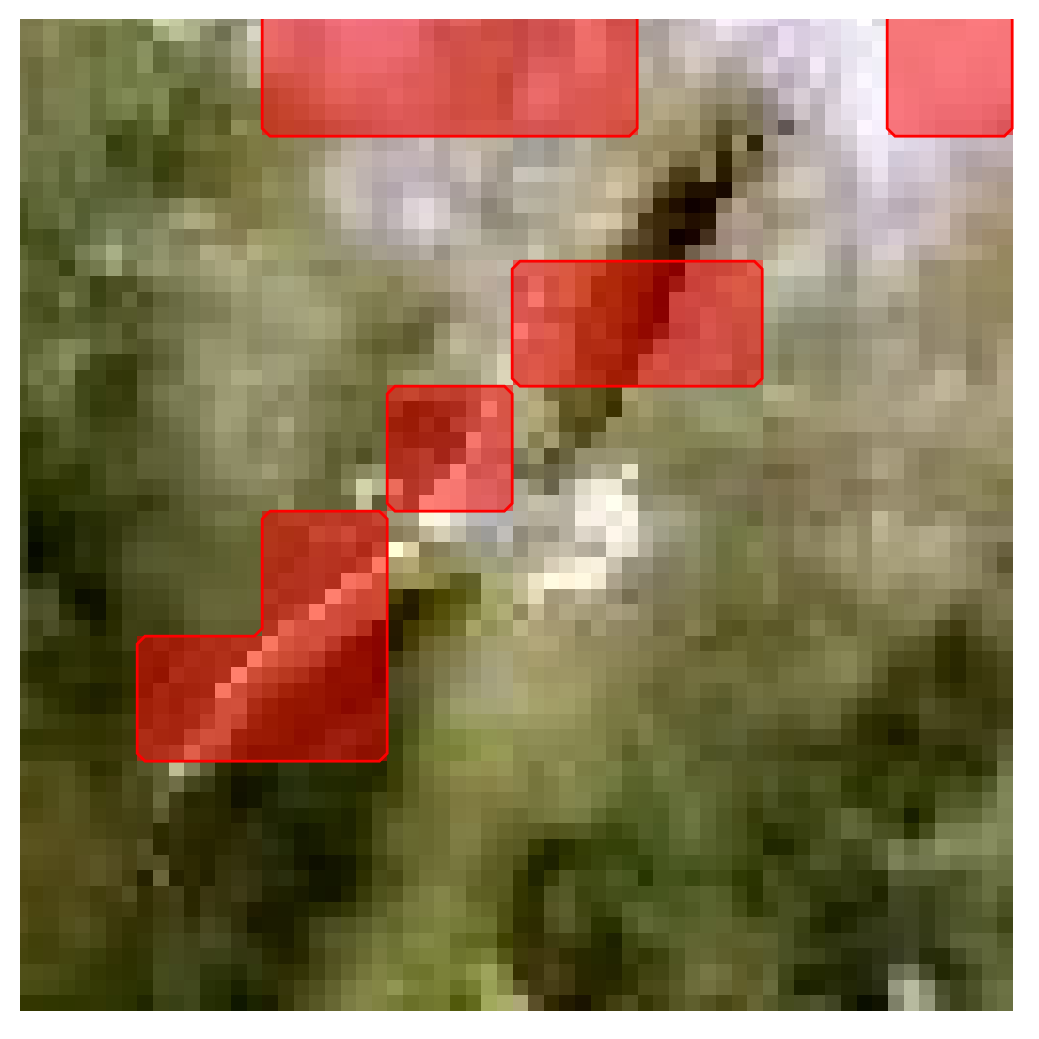

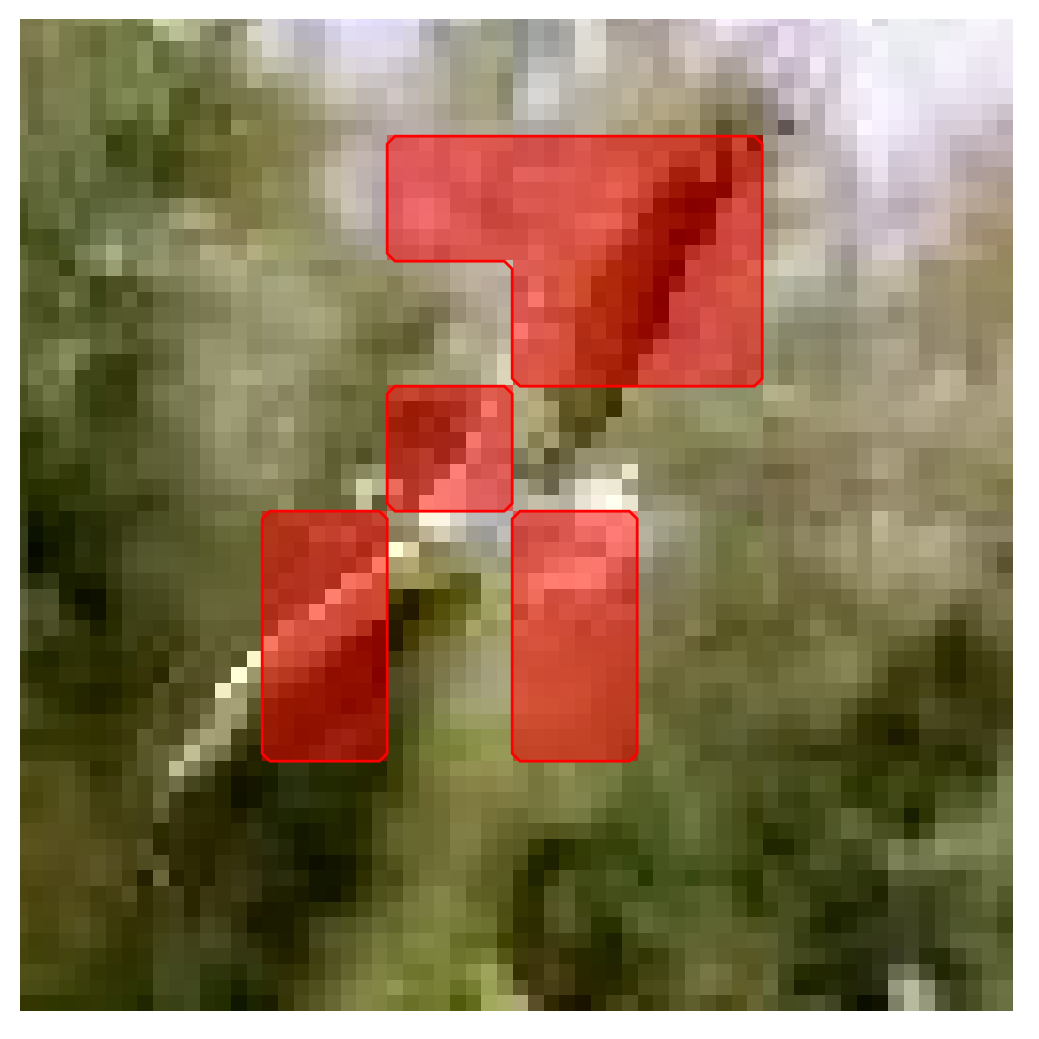

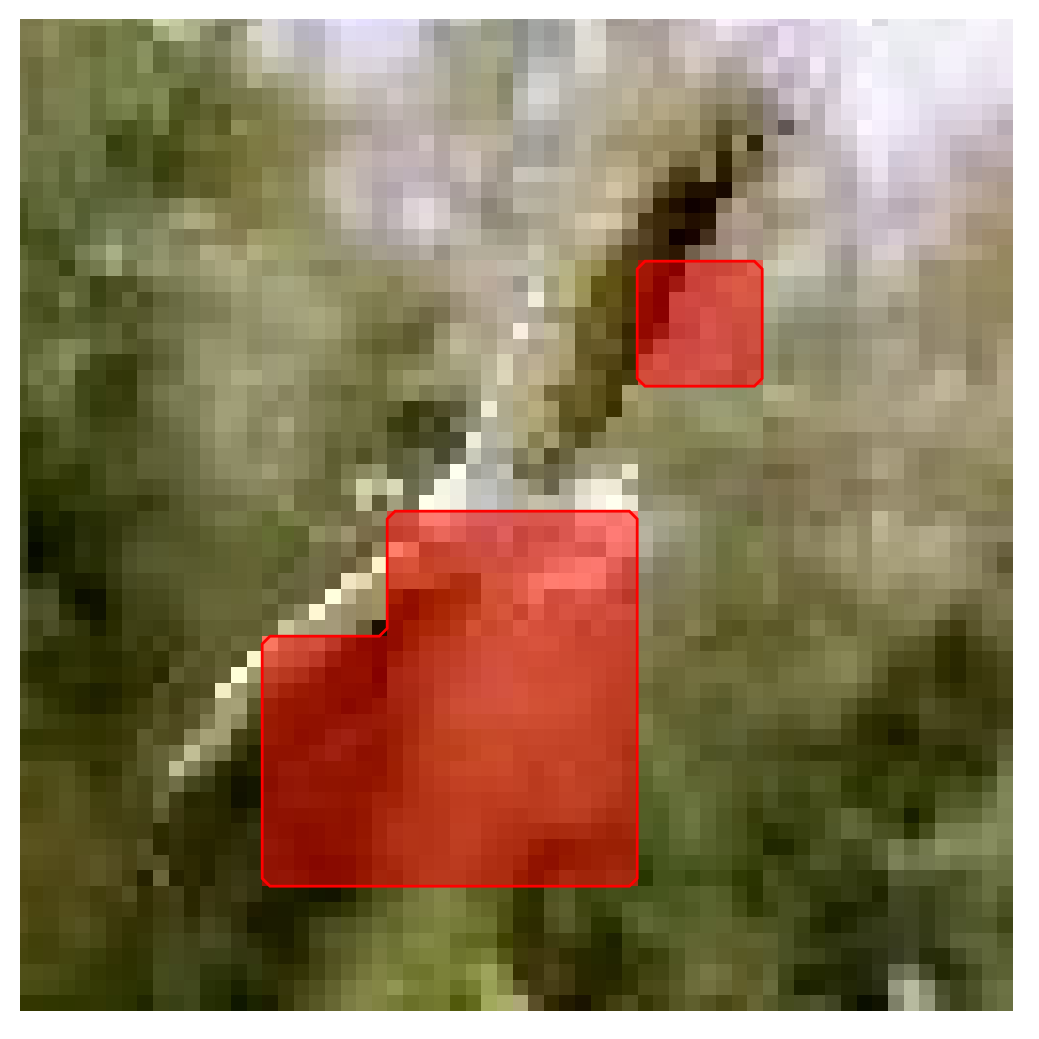

In [95]:
attentions, th_attn = get_attn_mask(img, model, model_config, threshold=0.3)

In [96]:
import torchvision

In [97]:
out_attentions = torch.stack([torch.tensor(att).repeat(3, 1, 1) * img for att in attentions])

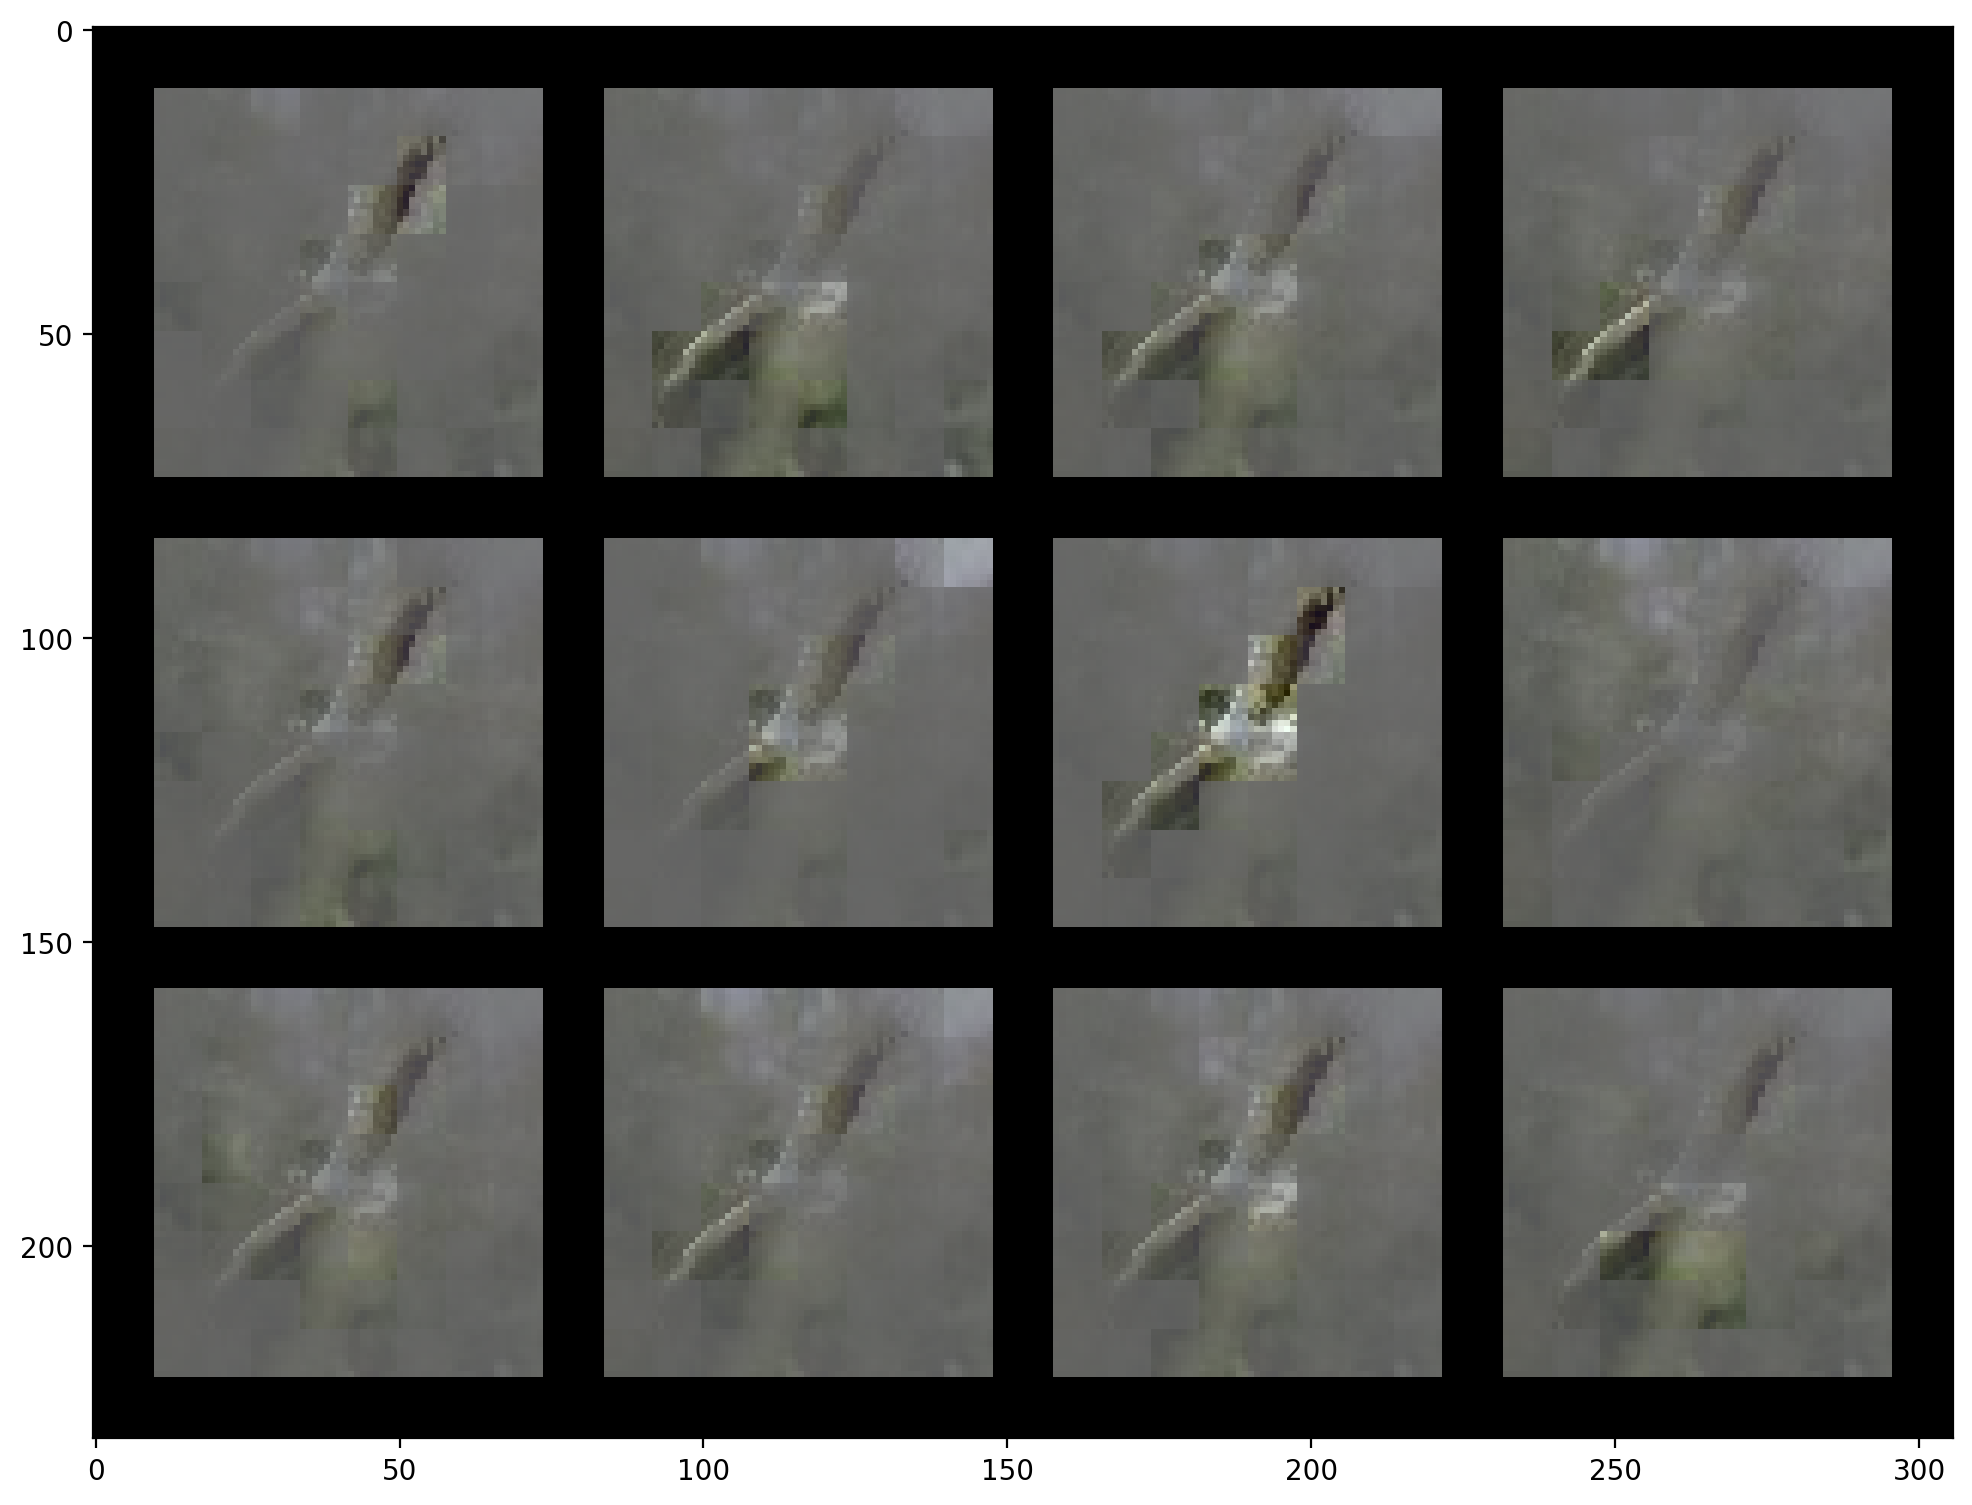

In [98]:
plt.figure(figsize=(12, 12))
plt.imshow(
    torchvision.utils.make_grid(out_attentions, nrow=4, normalize=True, padding=10).permute(1, 2, 0), cmap="Blues"
)

## 4. Low-Shot Learning (kNN, Linear Probing)


In [32]:
dataset_train = datasets.ImageFolder("datasets/tiny-imagenet-200/train/", transform=transform_val)
device = torch.device("mps")
model = model.to(device)

In [39]:
from tqdm import tqdm
import gc

train_features = []

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=25)
for img, label in tqdm(train_loader):
    img = img.to(device)
    train_features.append(model(img))
    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 19/1000 [00:13<11:55,  1.37it/s]


RuntimeError: MPS backend out of memory (MPS allocated: 17.67 GB, other allocations: 483.50 MB, max allowed: 18.13 GB). Tried to allocate 4.76 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
val_features = []
for img, label in tqdm(dataset_val):
    val_features.append(model(img.unsqueeze(0)))

In [ ]:
@torch.no_grad()
def knn_classifier(train_features, train_labels, test_features, test_labels, k, temp, num_classes=1000):
    top1, top5, total = 0.0, 0.0, 0
    train_features = train_features.t()
    num_test_images, num_chunks = test_labels.shape[0], 100
    imgs_per_chunk = num_test_images // num_chunks
    retrieval_one_hot = torch.zeros(k, num_classes).to(train_features.device)
    for idx in range(0, num_test_images, imgs_per_chunk):
        # get the features for test images
        features = test_features[
            idx : min((idx + imgs_per_chunk), num_test_images), :
        ]
        targets = test_labels[idx : min((idx + imgs_per_chunk), num_test_images)]
        batch_size = targets.shape[0]

        # calculate the dot product and compute top-k neighbors
        similarity = torch.mm(features, train_features)
        distances, indices = similarity.topk(k, largest=True, sorted=True)
        candidates = train_labels.view(1, -1).expand(batch_size, -1)
        retrieved_neighbors = torch.gather(candidates, 1, indices)

        retrieval_one_hot.resize_(batch_size * k, num_classes).zero_()
        retrieval_one_hot.scatter_(1, retrieved_neighbors.view(-1, 1), 1)
        distances_transform = distances.clone().div_(temp).exp_()
        probs = torch.sum(
            torch.mul(
                retrieval_one_hot.view(batch_size, -1, num_classes),
                distances_transform.view(batch_size, -1, 1),
            ),
            1,
        )
        _, predictions = probs.sort(1, True)

        # find the predictions that match the target
        correct = predictions.eq(targets.data.view(-1, 1))
        top1 = top1 + correct.narrow(1, 0, 1).sum().item()
        top5 = top5 + correct.narrow(1, 0, min(5, k)).sum().item()  # top5 does not make sense if k < 5
        total += targets.size(0)
    top1 = top1 * 100.0 / total
    top5 = top5 * 100.0 / total
    return top1, top5